In [1]:
!pip install numpy librosa sounddevice pyaudio
!pip install torch torchaudio scikit-learn matplotlib


In [2]:
import os
import numpy as np
import librosa

In [3]:
emotion_map={
    "01":"neutral","02":"calm","03":"happy","04":"sad",
    "05":"angry","06":"fearful","07":"disgust","08":"surprised"
}

In [4]:
file_path="../data/ravdess"

### checking if the path is exists or not

In [5]:
import os
os.path.exists(file_path)


True

This defines a function named extract_mfcc.

It takes two parameters:

file_path: the path to the audio file you want to process.

n_mfcc=40: optional argument specifying the number of MFCC coefficients to extract (default = 40).
librosa.load() loads the audio file from the given file_path.

signal is the actual audio waveform stored as a NumPy array. It contains amplitude values of the sound over time.

sr is the sampling rate (how many samples per second).

By setting sr=22050, you force the audio to be resampled to 22,050 Hz (a common standard in speech/audio processing). If the file has a different sampling rate, it will be converted to 22050.
librosa.feature.mfcc() computes the Mel Frequency Cepstral Coefficients from the audio signal.

y=signal: the waveform to analyze.

sr=sr: sampling rate used for correct frequency calculations.

n_mfcc=n_mfcc: number of MFCC features (rows) to extract.

Output: a 2-D NumPy array of shape (n_mfcc, time_frames)

Each row = 1 MFCC coefficient

Each column = value of that coefficient at a specific time frame.

MFCCs are compact features representing how humans perceive sound, commonly used in speech emotion recognition, speech recognition, etc.
mfcc.T transposes the MFCC matrix so shape becomes (time_frames, n_mfcc).

Taking np.mean(..., axis=0) means:

You compute the average of each MFCC coefficient across all time frames.

This compresses the 2-D MFCC feature matrix into a single 1-D feature vector of length n_mfcc.

Essentially, you summarize the entire audio clip into an average representation instead of a frame-by-frame series.
Returns the final MFCC feature vector.

Output shape: (n_mfcc,) — a single vector containing averaged MFCC values.

In [8]:
def extract_mfcc(file_path,n_mfcc=40):
    signal,sr=librosa.load(file_path,sr=22050)
    mfcc=librosa.feature.mfcc(y=signal,sr=sr,n_mfcc=n_mfcc)
    mfcc=np.mean(mfcc.T,axis=0)
    return mfcc
    

os.walk(DATA) recursively walks through all folders and subfolders inside the directory DATA.

It returns:

root → the current folder path being scanned

dirs → list of subdirectories inside the current folder

files → list of files in the current folder

The loop iterates over every folder and every file inside your dataset directory.

Iterates over each file discovered in the current root directory.
Ensures you only process audio files with extension .wav.

Skips any non-audio files (like metadata, readme files, etc.).
RAVDESS filenames follow a structured format like:
03-01-05-01-02-02-12.wav

file.split("-") breaks the filename into parts:
[2] selects the 3rd element from the split list (indexing starts at 0).

That element represents the emotion code in the RAVDESS dataset.

For example:

01 = neutral

02 = calm

03 = happy

04 = sad

05 = angry

06 = fearful

07 = disgust

08 = surprised

(Your EMOTION_MAP handles the exact mapping.)
os.path.join(root, file) builds the full path to the audio file.

extract_mfcc(...) is your function that:

Loads the audio file

Extracts MFCC features

Returns a feature vector

The output features is typically a 1-D NumPy array of length n_mfcc (e.g., 40).
X is your features dataset list.

Each entry corresponds to one audio sample’s MFCC feature vector.

Over the loop, X becomes a list of feature vectors.
y is your labels list.

For every feature vector in X, you store the corresponding target emotion label in y.

So at the end:

X[i] contains MFCC features of a speech file

y[i] contains the emotion label of that same file

Both lists stay aligned.
Converts the Python lists into NumPy arrays.

This is necessary because machine learning models expect NumPy arrays.

Final shapes usually:

X.shape → (num_samples, num_features)

y.shape → (num_samples,)

In [9]:
X,y=[],[]
DATA="../data/ravdess"
for root, dirs,files in os.walk(DATA):
    for file in files:
        if file.endswith(".wav"):
            emotion_code=file.split("-")[2]
            emotion=emotion_map[emotion_code]
            features=extract_mfcc(os.path.join(root,file))
            X.append(features)
            y.append(emotion)
X=np.array(X)
y=np.array(y)

In [10]:
import numpy as np
print(np.shape(X), np.shape(y))


(2880, 40) (2880,)


In [11]:
import torch 
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [12]:
encoder=LabelEncoder()
y=encoder.fit_transform(y)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

X_train=torch.tensor(X_train,dtype=torch.float32)
y_train=torch.tensor(y_train,dtype=torch.long)


Imports the required libraries.

torch and torch.nn are used to build and train the neural network.

LabelEncoder converts emotion labels (like “happy”, “sad”) into numeric values.

train_test_split splits the dataset into training and testing subsets.
Creates an instance of LabelEncoder.

This encoder will map each unique emotion label to an integer.
Fits the encoder on all labels in y and transforms them into numeric values.

Example:

["happy","sad","angry"] → [2,1,0]

Now the target labels are integers, which neural networks require.
Splits dataset into:

X_train, y_train → training data

X_test, y_test → testing data

test_size=0.2 means 20% of data is kept for testing and 80% for training.

Ensures your model is evaluated on unseen data.
Converts the NumPy array X_train into a PyTorch tensor.

dtype=torch.float32 ensures values are floating-point numbers.

Neural networks require tensor input, not NumPy arrays.
Converts training labels to PyTorch tensor.

dtype=torch.long is required because CrossEntropyLoss() expects labels as long integers (class indices).
Defines a new neural network class named LSTMEmotion.

It inherits from nn.Module, meaning it is a PyTorch neural network.
Constructor for the class.

super().__init__() initializes the parent nn.Module class properly.
Creates an LSTM layer.

Inputs:

40 → Input feature size. This matches your MFCC vector length (40 MFCC coefficients).

128 → Hidden state size (how many features LSTM learns internally).

batch_first=True

Means input will be in shape: (batch_size, sequence_length, feature_size)

Here: (batch, 1, 40) since you will add a sequence dimension later.
Fully Connected (dense) layer.

Input = 128 (output of LSTM hidden state)

Output = 8

Because there are 8 possible emotions in RAVDESS dataset.

Converts LSTM representation into emotion class scores.
Defines how data flows through the network.
Adds a sequence dimension.

Original x shape: (batch, 40)

After unsqueeze: (batch, 1, 40)

LSTM expects 3D input: (batch, sequence_length, features)

Here each sample is treated as a single-time-step sequence.
Passes data through the LSTM.

LSTM returns:

Output for every time step (ignored using _)

Hidden state h and cell state c (you only need hidden state).

h shape = (num_layers, batch, hidden_size)

You take the last layer’s hidden state.
Takes the last hidden state h[-1] (shape: (batch, 128)).

Passes it through the fully connected layer.

Output shape becomes (batch, 8) → one score per emotion class.

Returned values are logits (raw prediction scores).

In [13]:
class LSTMEmotion(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm=nn.LSTM(40,128,batch_first=True)
        self.fc=nn.Linear(128,8)

    def forward(self,x):
        x=x.unsqueeze(1)
        _,(h,_)=self.lstm(x)
        return self.fc(h[-1])
model=LSTMEmotion()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

Starts a loop that runs 50 times, meaning 50 training epochs.

One epoch = one full pass of the training dataset through the model.

epoch takes values from 0 to 49.
Resets (clears) all previously calculated gradients in the model.

Gradients accumulate by default in PyTorch.

If you do not clear them, gradients from previous backward passes will add up and corrupt learning.

This ensures each training step uses only current gradients.
Performs backpropagation.

Calculates gradients of the loss with respect to every model parameter.

These gradients tell the optimizer how to modify weights to reduce loss.
Updates model parameters using calculated gradients.

Uses Adam optimizer with learning rate 0.001.

This is the actual “learning” step where weights change.

In [14]:
for epoch in range(10000):
    optimizer.zero_grad()
    output=model(X_train)
    loss=criterion(output,y_train)
    loss.backward()
    optimizer.step()
    
print(loss.item()) 

0.00012455553223844618


In [15]:
torch.save(model.state_dict(), "../saved_models/model.pth")


In [16]:
from sklearn.metrics import classification_report

X_test_t=torch.tensor(X_test,dtype=torch.float32)
pred=model(X_test_t)
pred=torch.argmax(pred,axis=1)

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        72
           1       1.00      1.00      1.00        76
           2       0.92      0.95      0.94        77
           3       0.97      0.97      0.97        76
           4       1.00      0.94      0.97        69
           5       0.95      0.95      0.95        44
           6       0.86      0.95      0.90        80
           7       0.95      0.90      0.93        82

    accuracy                           0.95       576
   macro avg       0.96      0.96      0.96       576
weighted avg       0.96      0.95      0.96       576



In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
print(cm)


[[70  0  0  2  0  0  0  0]
 [ 0 76  0  0  0  0  0  0]
 [ 0  0 73  0  0  0  2  2]
 [ 0  0  0 74  0  0  2  0]
 [ 0  0  0  0 65  2  2  0]
 [ 0  0  2  0  0 42  0  0]
 [ 0  0  2  0  0  0 76  2]
 [ 0  0  2  0  0  0  6 74]]


<Figure size 800x600 with 0 Axes>

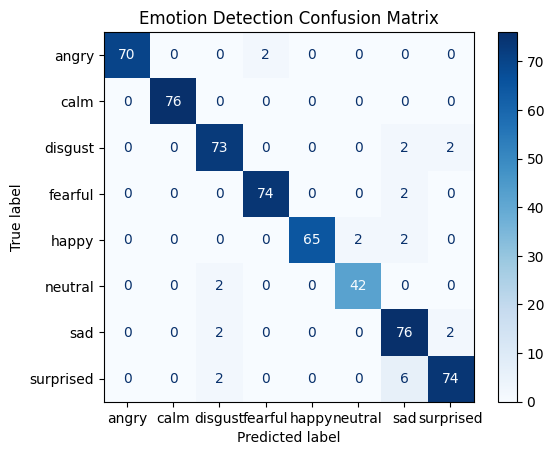

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_test_t = torch.tensor(X_test, dtype=torch.float32)
pred = model(X_test_t)
pred = torch.argmax(pred, axis=1)

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
plt.figure(figsize=(8,6))
disp.plot(cmap="Blues")
plt.title("Emotion Detection Confusion Matrix")
plt.show()
